<a href="https://colab.research.google.com/github/bhaweshiitk/ConformalLLM/blob/main/conformal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('default')
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Prompts in appendix.
# Reference gentle intro (sensitivity towards number of sample)
# Related section fine -- just discuss expected claibration error and cite the papers suggested.
# Elaborate on classification using LLMs.
# Can talk about calibration with some context on current setup.

In [4]:
os.chdir('./drive/MyDrive/llm_probs_gpt')

In [5]:
# data_dir = Path('prompt_data/gpt_4_prompt_data/')
data_dir = Path('./')

In [6]:
# Load softmax scores for each subjects corresponding to the 10 1-shot question prompt.
datasets = {
    'computer security': {
        'scores': np.load(data_dir / 'computer_security_scores.npy'),
        'targets': np.load(data_dir / 'computer_security_targets.npy'),
    },
    'high school computer science': {
        'scores': np.load(data_dir / 'high_school_computer_science_scores.npy'),
        'targets': np.load(data_dir / 'high_school_computer_science_targets.npy'),
    },
    'college computer science': {
        'scores': np.load(data_dir / 'college_computer_science_scores.npy'),
        'targets': np.load(data_dir / 'college_computer_science_targets.npy'),
    },
    'machine learning': {
        'scores': np.load(data_dir / 'machine_learning_scores.npy'),
        'targets': np.load(data_dir / 'machine_learning_targets.npy'),
    },
    'formal logic': {
        'scores': np.load(data_dir / 'formal_logic_scores.npy'),
        'targets': np.load(data_dir / 'formal_logic_targets.npy'),
    },
    'high school biology': {
        'scores': np.load(data_dir / 'high_school_biology_scores.npy'),
        'targets': np.load(data_dir / 'high_school_biology_targets.npy'),
    },
    'anatomy': {
        'scores': np.load(data_dir / 'anatomy_scores.npy'),
        'targets': np.load(data_dir / 'anatomy_targets.npy'),
    },
    'clinical knowledge': {
        'scores': np.load(data_dir / 'clinical_knowledge_scores.npy'),
        'targets': np.load(data_dir / 'clinical_knowledge_targets.npy'),
    },
    'college medicine': {
        'scores': np.load(data_dir / 'college_medicine_scores.npy'),
        'targets': np.load(data_dir / 'college_medicine_targets.npy'),
    },
    'professional medicine': {
        'scores': np.load(data_dir / 'professional_medicine_scores.npy'),
        'targets': np.load(data_dir / 'professional_medicine_targets.npy'),
    },
    'college chemistry': {
        'scores': np.load(data_dir / 'college_chemistry_scores.npy'),
        'targets': np.load(data_dir / 'college_chemistry_targets.npy'),
    },
    'marketing': {
        'scores': np.load(data_dir / 'marketing_scores.npy'),
        'targets': np.load(data_dir / 'marketing_targets.npy'),
    },
    'public relations': {
        'scores': np.load(data_dir / 'public_relations_scores.npy'),
        'targets': np.load(data_dir / 'public_relations_targets.npy'),
    },
    'management': {
        'scores': np.load(data_dir / 'management_scores.npy'),
        'targets': np.load(data_dir / 'management_targets.npy'),
    },
    'business ethics': {
        'scores': np.load(data_dir / 'business_ethics_scores.npy'),
        'targets': np.load(data_dir / 'business_ethics_targets.npy'),
    },
    'professional accounting': {
        'scores': np.load(data_dir / 'professional_accounting_scores.npy'),
        'targets': np.load(data_dir / 'professional_accounting_targets.npy'),
    },
}

In [7]:
# Accuracy cooresponding to each of the 10 GPT-4 1-shot question prompts for all 16 subjects.

dataset_accuracies = {}
for dataset, results in datasets.items():
    scores = results['scores']
    targets = results['targets']
    accuracies = []
    for score in scores:
        n = score.shape[0]
        correct = score.argmax(1) == targets
        accuracy = correct.sum() / n
        accuracies.append(accuracy)

    dataset_accuracies[dataset] = accuracies

In [8]:
fontsize = 24

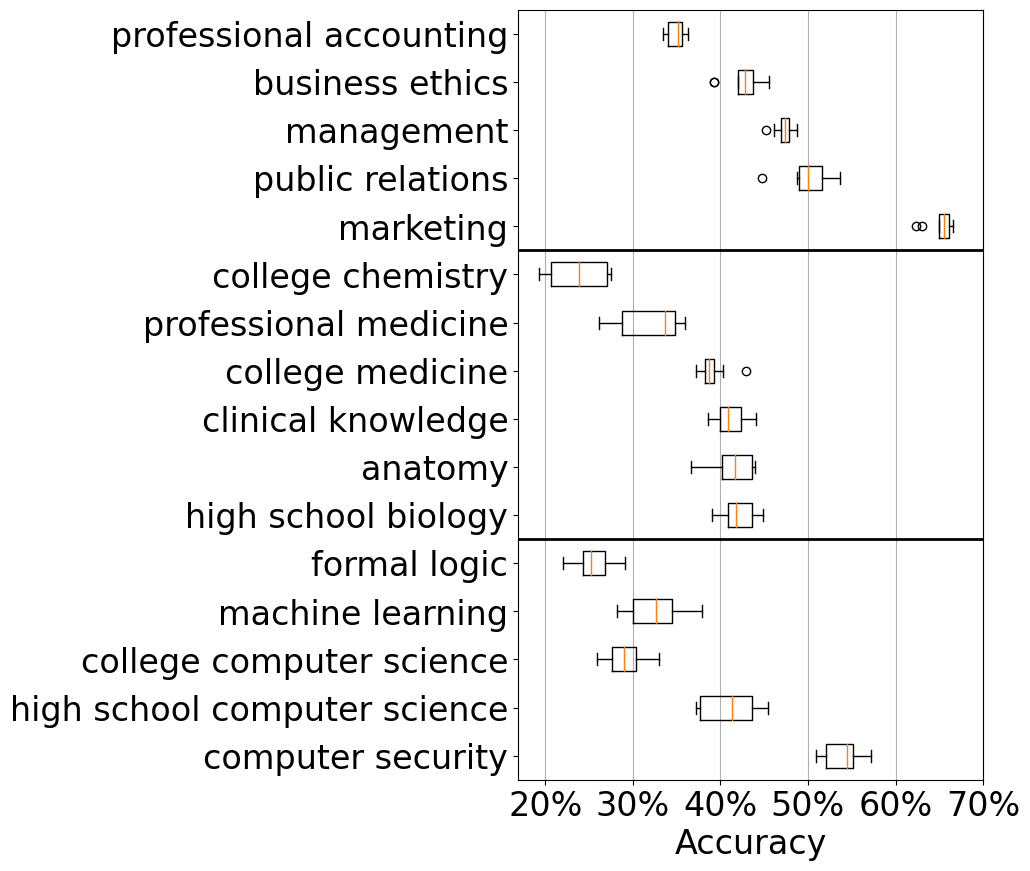

In [9]:
# Plot accuracy for each subject. Accuracy can slightly vary depending on
# specific one shot question used.

dataset_accuracies
plt.figure(figsize=(6, 10))

bars = plt.boxplot([x for x in dataset_accuracies.values()], vert=False)
plt.axhline(11.5, ls='-', lw=2, c='k')
plt.axhline(5.5, ls='-', lw=2, c='k')
plt.xticks([0.20, 0.3, 0.40, 0.50, 0.60, 0.70], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
plt.gca().set_yticklabels(dataset_accuracies.keys(), fontsize=fontsize)
plt.xlabel('Accuracy', fontsize=fontsize)
# plt.ylabel('Datasets', fontsize=fontsize)
plt.grid(ls='-', axis='x')
plt.savefig('accuracy.eps', bbox_inches='tight')
plt.show()


In [10]:
from functools import partial
import numpy as np
import torch


def calibrate_lac(scores, targets, alpha=0.1, return_dist=False):
    scores = torch.tensor(scores, dtype=torch.float)
    targets = torch.tensor(targets)
    assert scores.size(0) == targets.size(0)
    assert targets.size(0)
    n = torch.tensor(targets.size(0))
    assert n

    score_dist = torch.take_along_dim(1 - scores, targets.unsqueeze(1), 1).flatten()
    assert (
        0 <= torch.ceil((n + 1) * (1 - alpha)) / n <= 1
    ), f"{alpha=} {n=} {torch.ceil((n+1)*(1-alpha))/n=}"
    qhat = torch.quantile(
        score_dist, torch.ceil((n + 1) * (1 - alpha)) / n, interpolation="higher"
    )
    return (qhat, score_dist) if return_dist else qhat


def inference_lac(scores, qhat, allow_empty_sets=False):
    scores = torch.tensor(scores, dtype=torch.float)
    n = scores.size(0)

    elements_mask = scores >= (1 - qhat)

    if not allow_empty_sets:
        elements_mask[torch.arange(n), scores.argmax(1)] = True

    return elements_mask



def get_coverage(psets, targets, precision=None):
    psets = torch.tensor(psets)
    targets = torch.tensor(targets)
    psets = psets.clone()
    targets = targets.clone()
    n = psets.shape[0]
    coverage = psets[torch.arange(n), targets].float().mean().item()
    if precision is not None:
        coverage = round(coverage, precision)
    return coverage


def get_size(psets, precision=1):
    psets = psets.clone()
    size = psets.sum(1).float().mean().item()
    if precision is not None:
        size = round(size, precision)
    return size

In [11]:
len(scores) // 2

5

In [12]:
from collections import defaultdict
alpha = 0.1
# alpha = 0.2
num_trials = 100
all_q_hats = defaultdict(list)
all_scores = defaultdict(list)
all_psets = defaultdict(list)
all_targets = defaultdict(list)
other_all_coverage = defaultdict(dict)
other_all_size = defaultdict(dict)

for i in range(num_trials):
    for name, results in datasets.items():
        scores = results['scores'].mean(0)
        targets = results['targets']
        # scores = np.load(f'{dataset}_scores.npy')
        # targets = np.load(f'{dataset}_targets.npy')
        # print(dataset, scores.shape)

        # print(dataset, len(scores))
        # dataset_scores[dataset] = scores
        # dataset_targets[dataset] = targets

        # qs = []

        # for j in range(scores.shape[0]):
        index = np.arange(len(scores))
        np.random.shuffle(index)

        # n = int(0.2 * len(scores))
        n = len(scores) // 2
        cal_scores = scores[index][:n]
        val_scores = scores[index][n:]
        cal_targets = targets[index][:n]
        val_targets = targets[index][n:]

        q = calibrate_lac(cal_scores, cal_targets, alpha=alpha)
        # qs.append(q)

        psets = inference_lac(val_scores, q)
        all_psets[name].append(psets)
        all_scores[name].append(val_scores)
        all_targets[name].append(val_targets)

        # q_hat = np.mean(qs)
        q_hat = q

        for other_name, other_results in datasets.items():
            other_scores = other_results['scores'].mean(0)
            other_targets = other_results['targets']
            # other_scores = np.load(f'{other_dataset}_scores.npy')
            # other_targets = np.load(f'{other_dataset}_targets.npy')
            if other_scores.shape[0] == 0:
                continue

            # for j in range(other_scores.shape[0]):
            other_psets = inference_lac(other_scores, q_hat)
            if other_name not in other_all_coverage[name]:
                other_all_coverage[name][other_name] = []
                other_all_size[name][other_name] = []
            else:
                other_all_coverage[name][other_name].append(get_coverage(other_psets, other_targets))
                other_all_size[name][other_name].append(get_size(other_psets))

<ipython-input-10-dc8da9512e40>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)


In [13]:
print(f'COVERAGE at alpha: {alpha}')
print()
mean_coverage = np.zeros((len(other_all_coverage), len(other_all_coverage)))
for i, (first_dataset, results) in enumerate(other_all_coverage.items()):
    print(first_dataset.center(50, '-'))
    for j, (second_dataset, coverage) in enumerate(results.items()):
        if second_dataset == first_dataset:
            print(second_dataset, f'{np.mean(coverage):.0%} +/- {np.std(coverage):.0%}')
            print()
        mean_coverage[i][j] = np.mean(coverage)

print('********************')
print(f'SET SIZES at alpha: {alpha}')
print()

mean_size = np.zeros((len(other_all_size), len(other_all_size)))
for i, (first_dataset, results) in enumerate(other_all_size.items()):
    print(first_dataset.center(50, '-'))
    for j, (second_dataset, size) in enumerate(results.items()):
        if second_dataset == first_dataset:
            print(second_dataset, f'{np.mean(size):.1f} +/- {np.std(size):.1f}')
            print()
        mean_size[i][j] = np.mean(size)

COVERAGE at alpha: 0.1

----------------computer security-----------------
computer security 94% +/- 2%

-----------high school computer science-----------
high school computer science 93% +/- 3%

-------------college computer science-------------
college computer science 93% +/- 2%

-----------------machine learning-----------------
machine learning 93% +/- 2%

-------------------formal logic-------------------
formal logic 92% +/- 2%

---------------high school biology----------------
high school biology 91% +/- 2%

---------------------anatomy----------------------
anatomy 93% +/- 2%

----------------clinical knowledge----------------
clinical knowledge 91% +/- 2%

-----------------college medicine-----------------
college medicine 92% +/- 2%

--------------professional medicine---------------
professional medicine 92% +/- 2%

----------------college chemistry-----------------
college chemistry 94% +/- 2%

--------------------marketing---------------------
marketing 91% +/- 2%

----

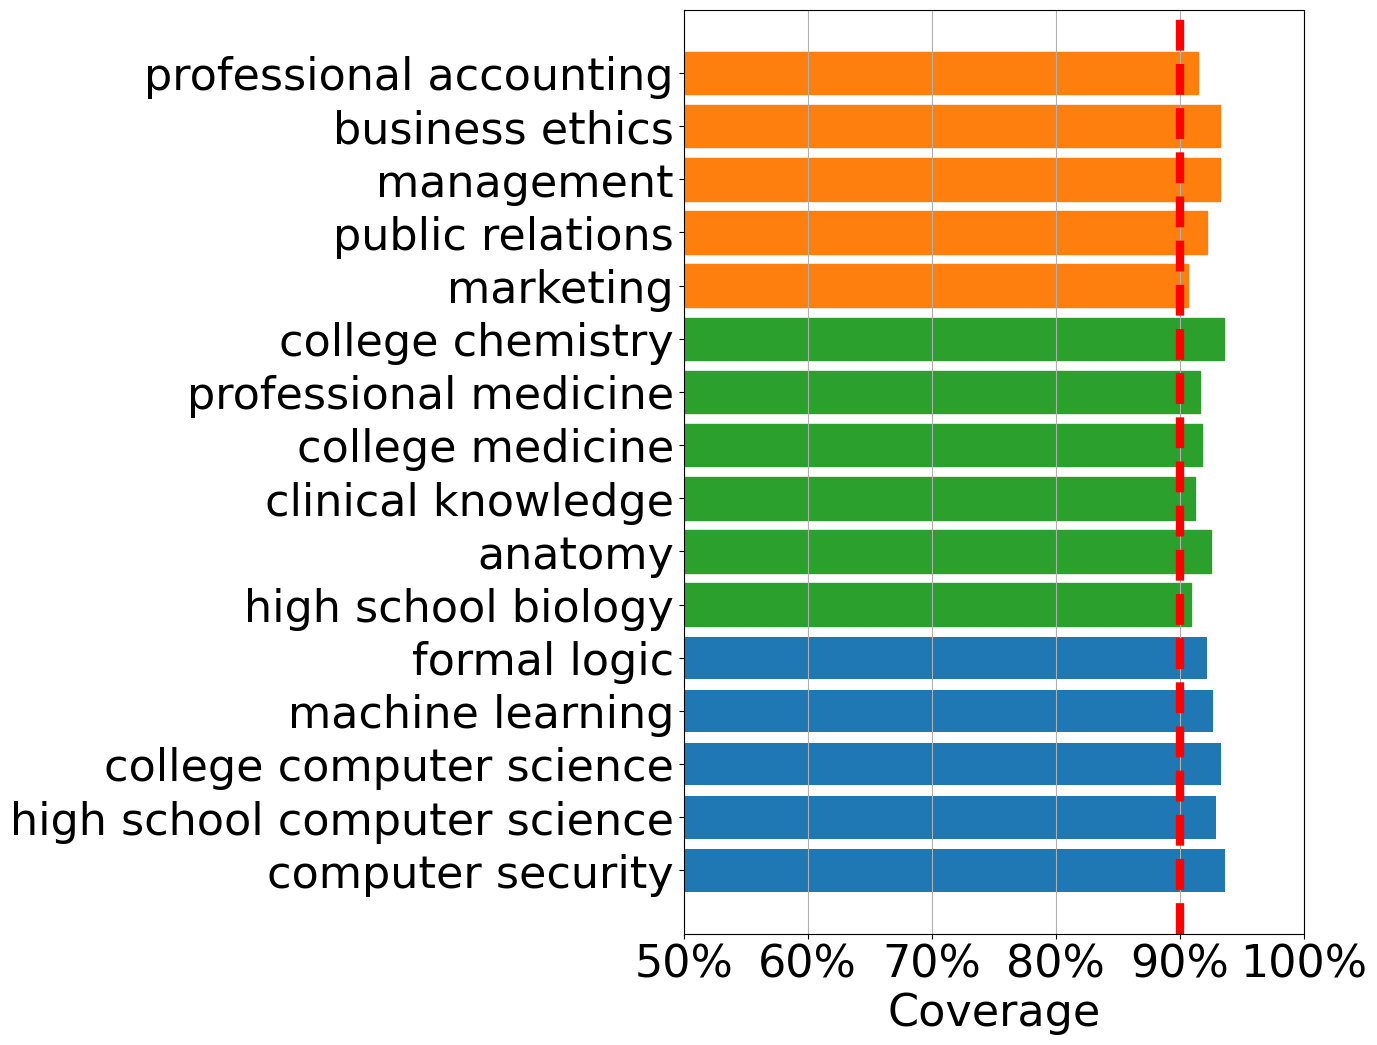

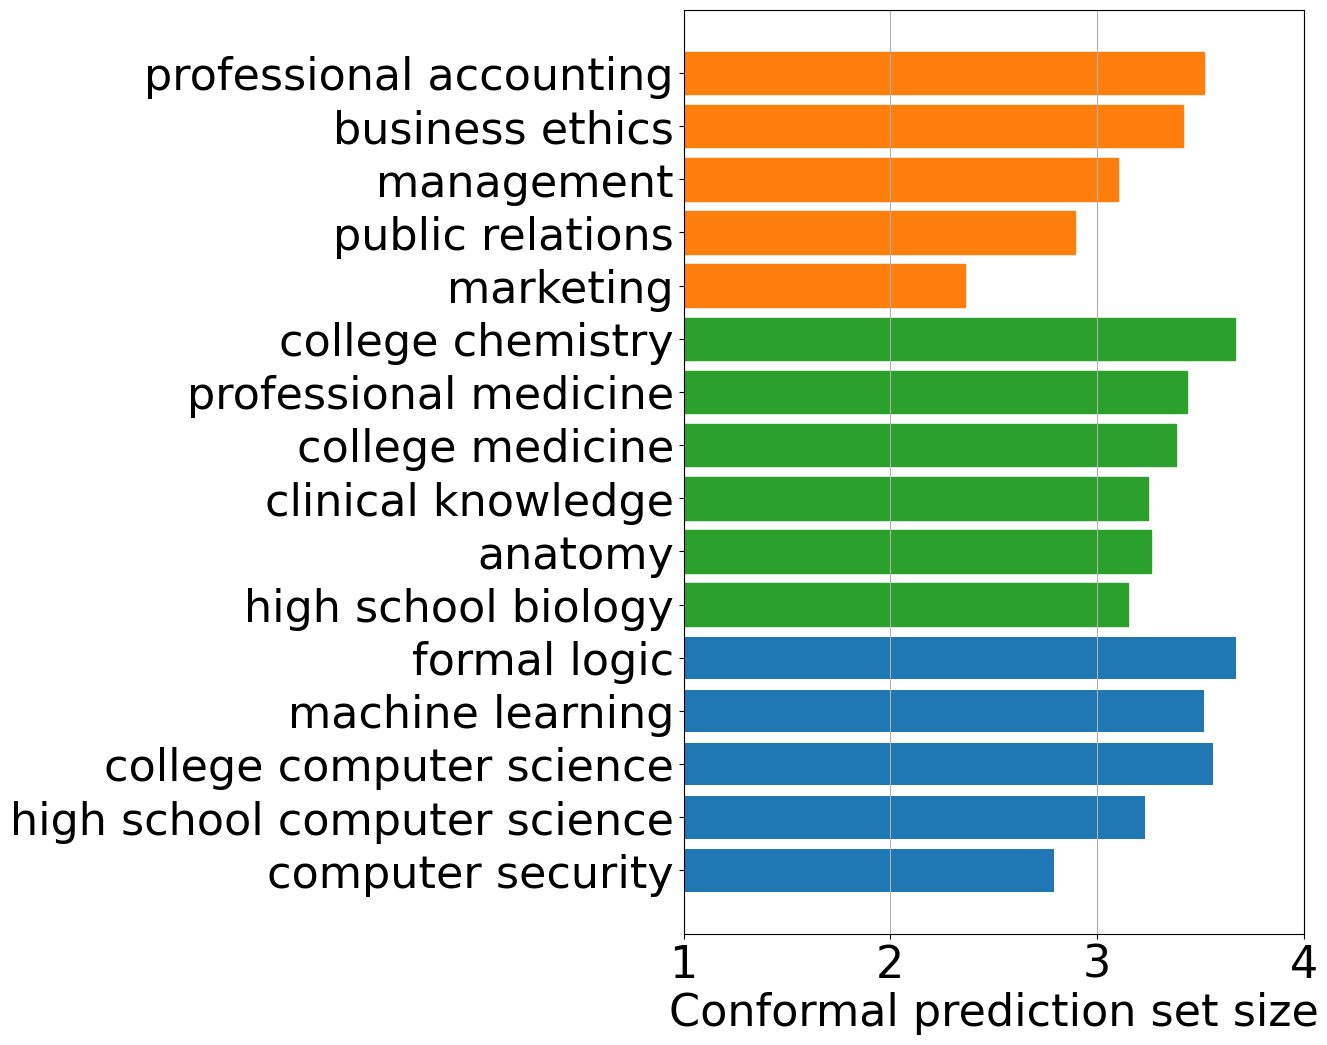

In [14]:
import matplotlib.pyplot as plt
fontsize = 32

plt.figure(figsize=(8, 12))

bars = plt.barh(list(datasets.keys()), [mean_coverage[i][i] for i in range(mean_coverage.shape[0])])
bars[5].set_color('C2')
bars[6].set_color('C2')
bars[7].set_color('C2')
bars[8].set_color('C2')
bars[9].set_color('C2')
bars[10].set_color('C2')
bars[11].set_color('C1')
bars[12].set_color('C1')
bars[13].set_color('C1')
bars[14].set_color('C1')
bars[15].set_color('C1')
# plt.axhline(10.5, ls='-', lw=2, c='k')
# plt.axhline(4.5, ls='-', lw=2, c='k')
plt.axvline(0.9, ls='--', lw=6, c='r')
plt.xlim(0.5, 1)
plt.xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])
plt.xlabel('Coverage', fontsize=fontsize)
# plt.ylabel('Datasets', fontsize=fontsize)
plt.grid(ls='-', axis='x')
plt.savefig('coverage.eps', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 12))
bars = plt.barh(list(datasets.keys()), [mean_size[i][i] for i in range(mean_size.shape[0])])
bars[5].set_color('C2')
bars[6].set_color('C2')
bars[7].set_color('C2')
bars[8].set_color('C2')
bars[9].set_color('C2')
bars[10].set_color('C2')
bars[11].set_color('C1')
bars[12].set_color('C1')
bars[13].set_color('C1')
bars[14].set_color('C1')
bars[15].set_color('C1')
plt.xlim(1, 4)
# plt.axvline(0.8, ls='--', lw=6, c='r')
# plt.axhline(10.5, ls='-', lw=2, c='k')
# plt.axhline(4.5, ls='-', lw=2, c='k')
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Conformal prediction set size', fontsize=fontsize)
# plt.ylabel('Datasets', fontsize=fontsize)
plt.grid(ls='-', axis='x')
plt.savefig('size.eps', bbox_inches='tight')
plt.show()

In [15]:
names = list(datasets.keys())

<ipython-input-16-1954eeab00f1>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{x:.1%}' for x in cbar.ax.get_yticks()])


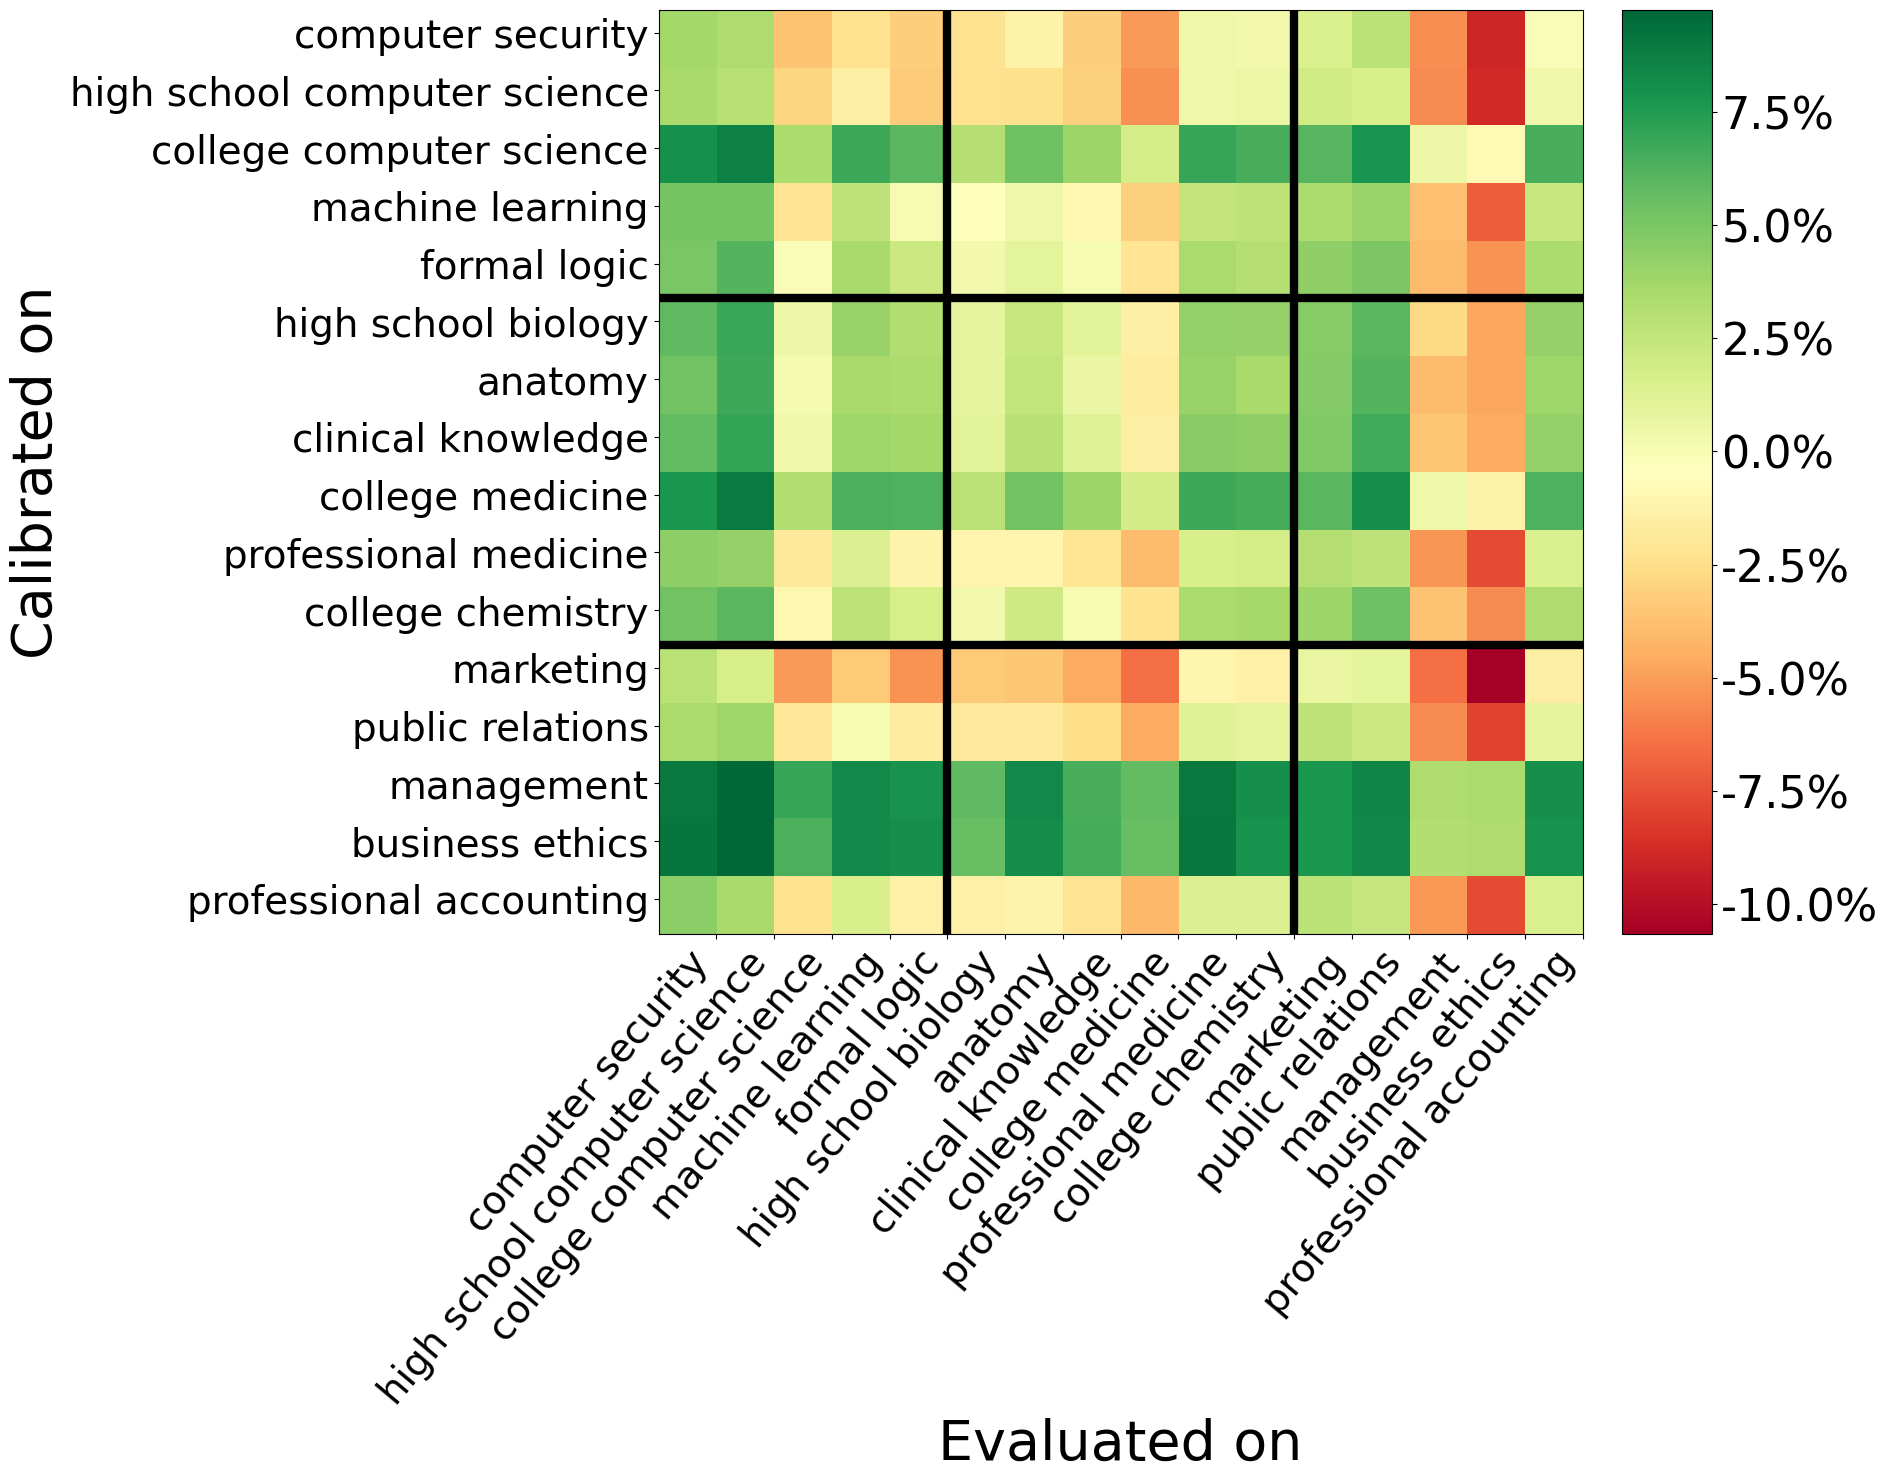

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.grid(False)
plt.imshow(
    mean_coverage - (1-alpha),
    # cmap=plt.get_cmap('seismic'),
    cmap=plt.get_cmap('RdYlGn'),
)
plt.xticks(np.arange(len(names)) + 0.5, names, fontsize=fontsize-4, rotation=50, ha='right', va='top')
plt.yticks(np.arange(len(names)) - 0.1, names, fontsize=fontsize-4)
plt.xlabel('Evaluated on', fontsize=fontsize+8)
plt.ylabel('Calibrated on', fontsize=fontsize+8)
plt.axhline(10.5, ls='-', lw=6, c='k')
plt.axhline(4.5,  ls='-', lw=6, c='k')
plt.axvline(10.5, ls='-', lw=6, c='k')
plt.axvline(4.5,  ls='-', lw=6, c='k')
# for i in range(mean_coverage.shape[0]):
#     for j in range(mean_coverage.shape[1]):
#         color = 'white' if mean_coverage[j, i] > mean_coverage.max() / 2 else 'black'
#         plt.text(i, j,
#                  f'{mean_coverage[j, i] - (1-alpha):.2f}',
#                  fontsize=12,
#                  color=color,
#                  horizontalalignment='center',
#                 )
cax = plt.axes([0.93, 0.11, 0.075, 0.77])
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_yticklabels([f'{x:.1%}' for x in cbar.ax.get_yticks()])
# plt.tick_params('x')
plt.savefig(f'calibration-{alpha}.eps', bbox_inches='tight')
plt.show()

In [17]:
def get_accuracy(scores, targets):
    n = len(scores)
    correct = (scores.argmax(1) == targets).sum()
    accuracy = correct / n

    return accuracy

acc_results = {}
cov_results = {}
# cnt_results = {}
for dataset in datasets.keys():
    stratified_coverage = defaultdict(list)
    stratified_accuracy = defaultdict(list)
    stratified_count = defaultdict(list)
    for k in range(1, 5):
        for i, psets in enumerate(all_psets[dataset]):
            mask = psets.sum(1) == k
            psets = psets[mask]
            scores = all_scores[dataset][i][mask]
            # if len(all_targets[dataset][mask])>3:
            stratified_coverage[k].append(get_coverage(psets, all_targets[dataset][i][mask]))
            stratified_accuracy[k].append(get_accuracy(scores, all_targets[dataset][i][mask]))
        # stratified_count[k] = len(all_targets[dataset][mask])

    # plt.plot(stratified_coverage.keys(), stratified_coverage.values(), label=dataset)
    acc_results[dataset] = dict(stratified_accuracy)
    cov_results[dataset] = dict(stratified_coverage)
    # cnt_results[dataset] = stratified_count


<ipython-input-10-dc8da9512e40>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psets = torch.tensor(psets)
<ipython-input-17-f921576800b9>:4: RuntimeWarning: invalid value encountered in long_scalars
  accuracy = correct / n


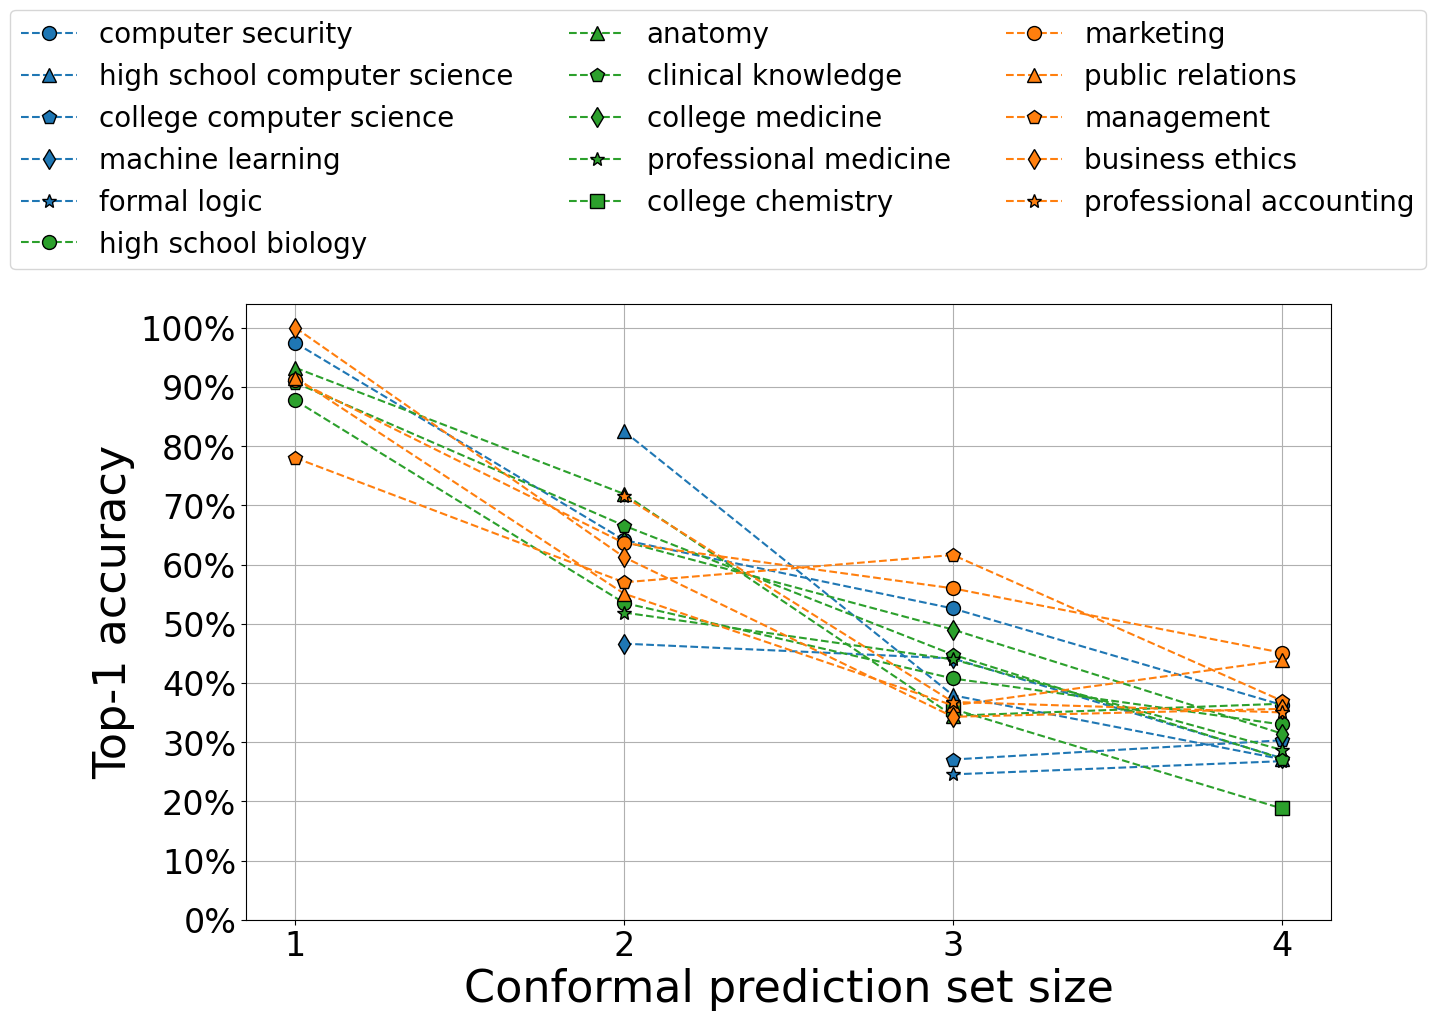

In [18]:
fontsize = 24
plt.figure(figsize=(14, 8))

markers = ['o', '^', 'p', 'd', '*'] + ['o', '^', 'p', 'd', '*', 's'] + ['o', '^', 'p', 'd', '*']
for i, (dataset, acc) in enumerate(acc_results.items()):
    if dataset in names[:5]:
        c = 'C0'
    elif dataset in names[5:11]:
        c = 'C2'
    elif dataset in names[10:]:
        c = 'C1'
    plt.plot(acc.keys(), [np.mean(x) for x in acc.values()], label=dataset, ls='--', marker=markers[i], markersize=10, c=c, markeredgecolor='k')

plt.legend(fontsize=fontsize-4, bbox_to_anchor=(1.1, 1.50), ncol=3)
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=fontsize)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.xlabel('Conformal prediction set size', fontsize=fontsize+8)
plt.ylabel('Top-1 accuracy', fontsize=fontsize+8)
plt.grid(True,)
plt.savefig('selective-accuracy.eps', bbox_inches='tight')
plt.show()

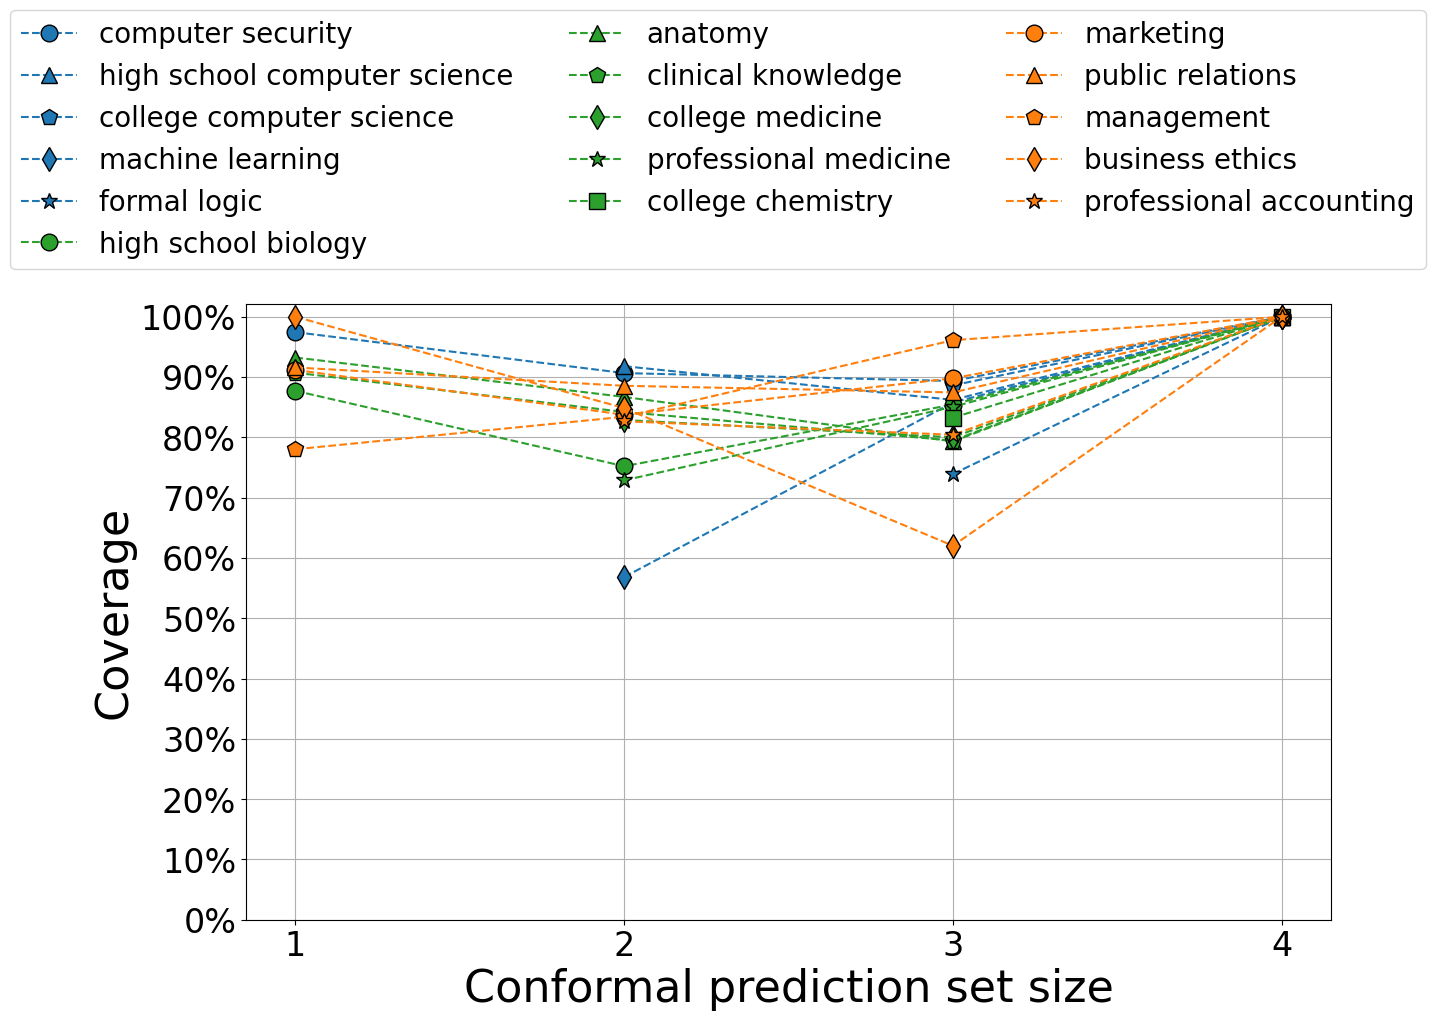

In [19]:

fontsize = 24
plt.figure(figsize=(14, 8))

for i, (dataset, acc) in enumerate(cov_results.items()):
    if dataset in names[:5]:
        c = 'C0'
    elif dataset in names[5:11]:
        c = 'C2'
    elif dataset in names[10:]:
        c = 'C1'
    plt.plot(acc.keys(), [np.mean(x) for x in acc.values()], label=dataset, ls='--', marker=markers[i], markersize=12, c=c, markeredgecolor='k')

plt.legend(fontsize=fontsize-4, bbox_to_anchor=(1.1, 1.50), ncol=3)
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.xlabel('Conformal prediction set size', fontsize=fontsize+8)
plt.ylabel('Coverage', fontsize=fontsize+8)
plt.grid(True,)
plt.savefig('stratified-coverage.eps', bbox_inches='tight')
plt.show()

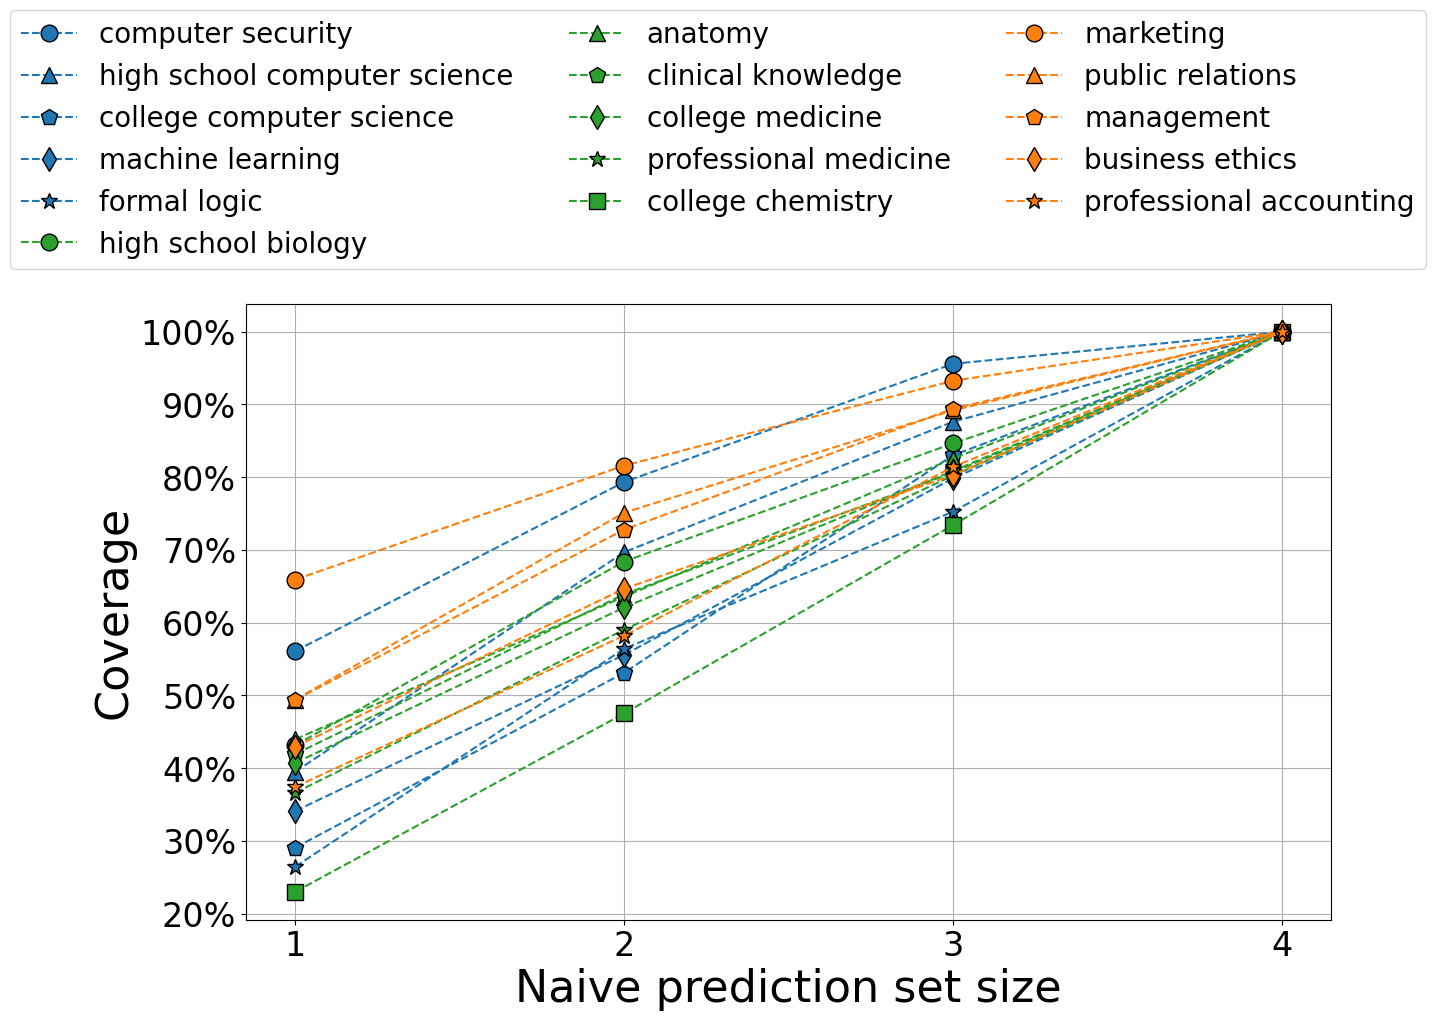

In [20]:
naive_results = {}
for dataset in datasets.keys():
    naive_coverage = defaultdict(list)
    for k in range(1, 5):
        for i, scores in enumerate(all_scores[dataset]):
            sorted_scores = np.flip(scores.argsort(), 1)[:, :k]
            psets = np.eye(4)[sorted_scores].sum(1)
            naive_coverage[k].append(get_coverage(psets.copy(), all_targets[dataset][i]))

    naive_results[dataset] = dict(naive_coverage)

fontsize = 24
plt.figure(figsize=(14, 8))

for i, (dataset, acc) in enumerate(naive_results.items()):
    if dataset in names[:5]:
        c = 'C0'
    elif dataset in names[5:11]:
        c = 'C2'
    elif dataset in names[10:]:
        c = 'C1'
    plt.plot(acc.keys(), [np.mean(x) for x in acc.values()], label=dataset, ls='--', marker=markers[i], markersize=12, c=c, markeredgecolor='k')

plt.legend(fontsize=fontsize-4, bbox_to_anchor=(1.1, 1.50), ncol=3)
plt.xticks([1, 2, 3, 4], fontsize=fontsize)
plt.yticks(np.arange(0.2, 1.1, 0.1), fontsize=fontsize)
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.xlabel('Naive prediction set size', fontsize=fontsize+8)
plt.ylabel('Coverage', fontsize=fontsize+8)
plt.grid(True,)
plt.savefig('navie-coverage.eps', bbox_inches='tight')
plt.show()

In [21]:
import pickle

In [22]:
with open('../../../accuracy_gpt_prompts_10.pkl', 'rb') as f:
    gpt_acc = pickle.load(f)

with open('../../../accuracy_mmlu_prompts_10.pkl', 'rb') as f:
    mmlu_acc = pickle.load(f)

In [23]:
len(names)

16

<ipython-input-24-67924fe3cabe>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()], fontsize=fontsize-4)


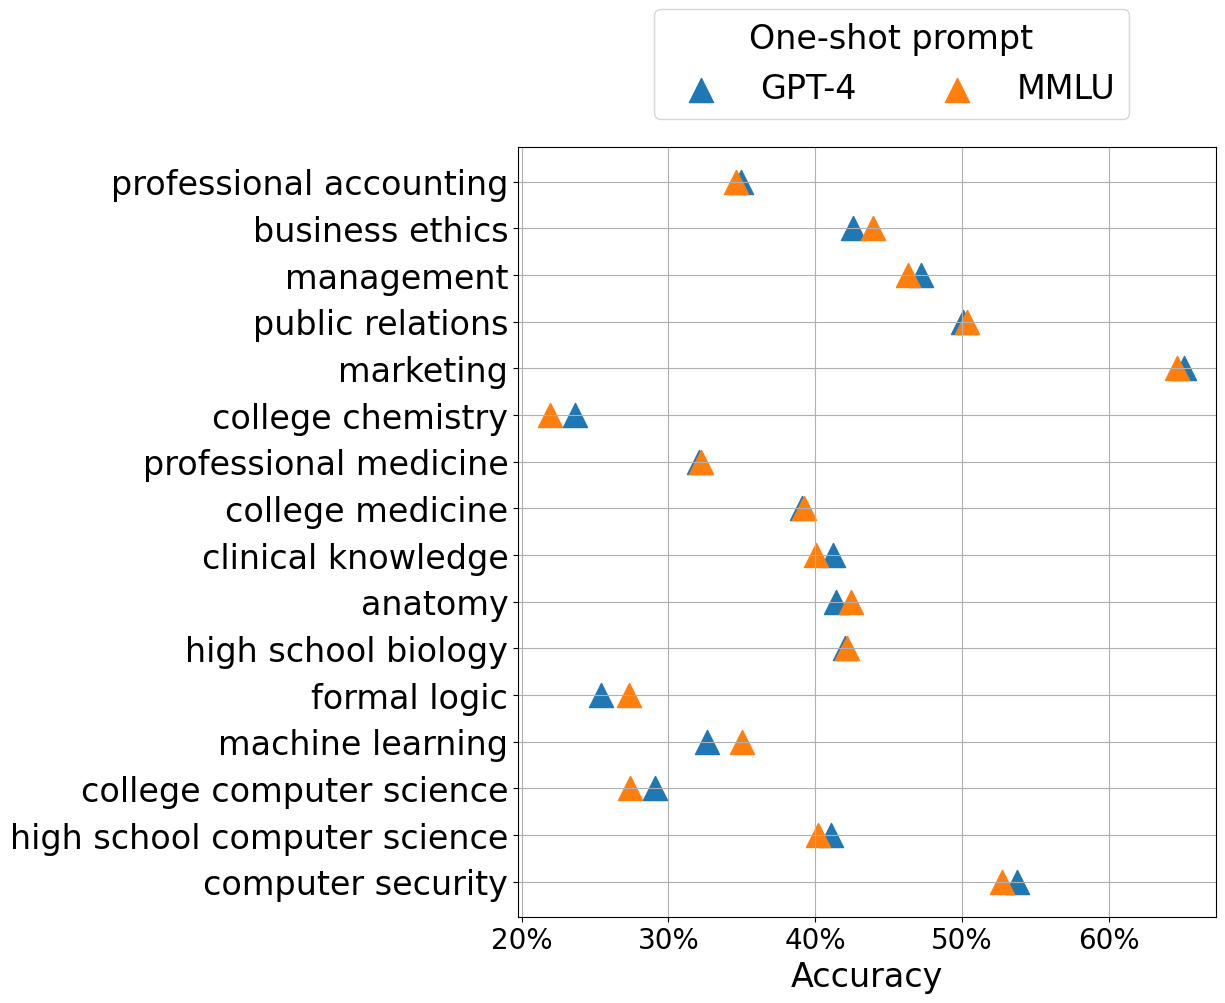

In [24]:
plt.figure(figsize=(9, 10))
names = []
counter = 0
for name in datasets.keys():
    dataset = name.replace(' ', '_')
    if dataset in gpt_acc and dataset in mmlu_acc:
        names.append(name)
        if counter == 0:
            gpt_label = 'GPT-4'
            mmlu_label = 'MMLU'
        else:
            gpt_label = None
            mmlu_label = None
        plt.scatter(np.mean(gpt_acc[dataset]), counter, label=gpt_label, c='C0', s=300, marker='^')
        plt.scatter(np.mean(mmlu_acc[dataset]), counter, label=mmlu_label, c='C1', s=300, marker='^')
        counter += 1

# plt.axhline(11.5, ls='-', lw=2, c='k')
# plt.axhline(5.5, ls='-', lw=2, c='k')
plt.yticks(range(len(names)), fontsize=12)
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()], fontsize=fontsize-4)
plt.gca().set_yticklabels(names, fontsize=fontsize)
plt.xlabel('Accuracy', fontsize=fontsize)
# plt.ylabel('Datasets', fontsize=fontsize)
plt.grid(ls='-', axis='both')
plt.legend(fontsize=fontsize, title='One-shot prompt', title_fontsize=fontsize, bbox_to_anchor=(0.9, 1.20), ncol=2)
plt.savefig('gpt-vs-mmlu.eps', bbox_inches='tight')
plt.show()